In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import plotly
import plotly.graph_objects as go
import seaborn as sns
from sympy import symbols, Eq, solve


import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from scipy.integrate import solve_ivp

The following code block is a model for the fate and transport of PCBs in the water column of the Anacostia River in Washington DC. While this code is specifically designed for the Anacostia River, this serves as a framework for developing fate and transport models in environmental matrices contaminated with any pollutants of concern.

In [2]:
# Step 1 - define our constants:
# Assume no PCB contamination from upstrem of Reach 7 for now
RiverParameters = pd.read_csv('PCB Model - Better River Inputs.csv')
CongenerParameters = pd.read_csv('PCB Model - Congener specific parameters.csv')
SedimentConc = pd.read_csv('PCB Model - Sediment Concentration.csv')
Qin = RiverParameters['Qin (m3/day)'] #m^3/day
Qout = RiverParameters['Qout (m3/day)'] #m^3/day
Vw = RiverParameters['Vw (m3)'] #m^3
DOC = RiverParameters['DOC (kg/m3)'] #kg/m^3
WC_fOC = RiverParameters['fOC'] #unitless
POC = RiverParameters['POC (kg/m3)'] #kg/m^3
Aw = RiverParameters['Aw (m2)'] #m^2
Vs = RiverParameters['VS (m/day)'] #m/day
Sed_fOC = RiverParameters['Sediment fOC'] #unitless
Vr = RiverParameters['VR (m/day)'] #m/day
log_Koc = CongenerParameters['log KOC']
Koc = 10**log_Koc #m^3/kg
log_Kdoc = CongenerParameters['log KDOC']
Kdoc = 10**log_Kdoc #m^3/kg
Vd = CongenerParameters['VD (m/day)'] #m/day
cAIR = CongenerParameters['Cair (ng/m3)'] #ng/m^3
Kaw = CongenerParameters['Kaw'] #unitless
Vaw = CongenerParameters['Vaw(m/day)'] #m/day
Csed_R7 = SedimentConc['R7 ng/m3'] #ng/m^3
Csed_R67 = SedimentConc['R67 ng/m3'] #ng/m^3
Csed_R456 = SedimentConc['R456 ng/m3'] #ng/m^3
Csed_KL = SedimentConc['KL ng/m3'] #ng/m^3
Csed_R123 = SedimentConc['R123 ng/m3'] #ng/m^3
Csed_WC = SedimentConc['WC ng/m3'] #ng/m^3
phi = 0.7 #unitless
rho = 2282 #kg/m^3
newarray = np.arange(86, dtype=np.int64)
cin = np.full_like(newarray, 50) #ng/m^3

# Step 2 - define a function which calculates the derivative
#c is cTOT
#All concentration units are in ng/m^3
def dc_dt(t, c, Qin, cin, Qout, Vaw, Vw, Vs, POC, DOC, Koc, Kdoc, Sed_fOC, Vr, Aw, Vd, phi,
          Csed_R7, Csed_R67, Csed_R456, Csed_KL, Csed_R123, Csed_WC, rho, cAIR, Kaw):

    '''
    This function calculates the rate of change over time of PCB concentration in the water column of
    6 river stretches of the Anacostia River in Washington DC sequentially. This function is intended to
    be used with the solve_ivp command from the scipy python package to solve for the concentration of PCB
    congeners in each stretch of the river at given time points. This function works by solving iteratively
    through a list of PCB congener parameters, and therefore must be used with a for loop when attempting to
    use with the solve_ivp command.
    
    Parameters
    t - Time range (days) => Must be passed as a list of 2 values
    phi - Sediment porosity (unitless)
    rho - Sediment density (kg/m^3)
    
    River Parameters (these parameters must be passed in as list of 6 values each):
    Qin - Flow rate into river segment (m^3/day)
    Qout - Flow rate out of river segment (m^3/day)
    Vw - Volume of water in river segment at mean tide (m^3)
    Vs - Rate of settling of suspended particles in water column (m/day)
    POC - Concentration of particulate organic carbon in water column (kg/m^3)
    DOC - Concentration of dissolved organic carbon in water column (kg/m^3)
    Sed_fOC - Fraction of sediment that is organic carbon (unitless)
    Vr - Rate of resuspension of particles into the water column (m/day)
    Aw - Surface area of water surface and sediment surface (assumed to be equal) (m^2)
    
    Congener Parameters (these parameters must be passed in as list of 86 values each):
    c - Initial concentration for each PCB congener (ng/m^3)
    cin - PCB concentration flowing into river stretch 1 (ng/m^3)
    Vaw - Rate of exchange between air-water interface (m/day)
    Koc - Organic carbon partition coefficient for particulate organic carbon in water column (m^3/kg)
    Kdoc - Dissolved organic carbon partition coefficient for dissolved organic carbon in water column (m^3/kg)
    Vd - Rate of diffusion of PCB between sediment-water interface
    Csed_R7 - Concentration of PCB in sediment of Reach 7 (ng/m^3)
    Csed_R67 - Concentration of PCB in sediment of Reach 67 (ng/m^3)
    Csed_R456 - Concentration of PCB in sediment of Reach 456 (ng/m^3)
    Csed_KL - Concentration of PCB in sediment of Kingman Lake (ng/m^3)
    Csed_R123 - Concentration of PCB in sediment of Reach 123 (ng/m^3)
    Csed_WC - Concentration of PCB in sediment of Washington Channel (ng/m^3)
    cAIR - Concentration of PCB in the air above the Anacostia River (ng/m^3)
    Kaw - Air-water partitioning coefficient (unitless)
    
    To calculate the rate of change in each river segment, the function first calculates the fraction of
    PCB that is freely dissolved in the water column (Fdw), the fraction of PCB that is partitioned to the
    particulate organic carbon in the water column (Fpw), the fraction of PCB that is freely dissolved in the
    sediment porewater (Fds), and the fraction of PCB that is partitioned to the sediment (Fps). With these
    fractions calculated, the function can calculate the rate of change in the river segment, and, in conjunction
    with the solve_ivp command from scipy, the code can calculate the concentration of PCB in the system at
    any given time point.
    '''
    
    # Reach 7
    dcdt_R7 = np.zeros(1)
    Fdw_R7 = 1/(1+(POC[0]*Koc[i])+(DOC[0]*Kdoc[i])) #unitless
    Fpw_R7 = (POC[0]*Koc[i])/(1+(POC[0]*Koc[i])+(DOC[0]*Kdoc[i])) #unitless
    Fds_R7 = 1/(phi+((1-phi)*rho*Sed_fOC[0]*Koc[i])) #unitless
    Fps_R7 = 1 - Fds_R7 #unitless
    dcdt_R7 = ((Qin[0]*cin[i])-(Qout[0]*c[0])-(Vaw[i]*(c[0]*Fdw_R7-cAIR[i]/Kaw[i])*Aw[0])
             -(Vs[0]*Aw[0]*c[0]*Fpw_R7)+(Vr[0]*Aw[0]*Csed_R7[i]*Fps_R7)
             +(Vd[i]*(Csed_R7[i]*Fds_R7-c[0]*Fdw_R7)*Aw[0]))/Vw[0] #ng/m^3-d

    # Reach 67
    dcdt_R67 = np.zeros(1)
    cin_R67 = c[0]*Fdw_R7
    Fdw_R67 = 1/(1+(POC[1]*Koc[i])+(DOC[1]*Kdoc[i]))
    Fpw_R67 = (POC[1]*Koc[i])/(1+(POC[1]*Koc[i])+(DOC[1]*Kdoc[i]))
    Fds_R67 = 1/(phi+((1-phi)*rho*Sed_fOC[1]*Koc[i]))
    Fps_R67 = 1 - Fds_R67
    dcdt_R67 = ((Qin[1]*cin_R67)-(Qout[1]*c[1])-(Vaw[i]*(c[1]*Fdw_R67-cAIR[i]/Kaw[i])*Aw[1])
              -(Vs[1]*Aw[1]*c[1]*Fpw_R67)+(Vr[1]*Aw[1]*Csed_R67[i]*Fps_R67)
              +(Vd[i]*(Csed_R67[i]*Fds_R67-c[1]*Fdw_R67)*Aw[1]))/Vw[1]

    # Reach 456
    dcdt_R456 = np.zeros(1)
    cin_R456 = c[1]*Fdw_R67
    Fdw_R456 = 1/(1+(POC[2]*Koc[i])+(DOC[2]*Kdoc[i]))
    Fpw_R456 = (POC[2]*Koc[i])/(1+(POC[2]*Koc[i])+(DOC[2]*Kdoc[i]))
    Fds_R456 = 1/(phi+((1-phi)*rho*Sed_fOC[2]*Koc[i]))
    Fps_R456 = 1 - Fds_R456
    dcdt_R456 = ((Qin[2]*cin_R456)-(Qout[2]*c[2])-(Vaw[i]*(c[2]*Fdw_R456-cAIR[i]/Kaw[i])*Aw[2])
               -(Vs[2]*Aw[2]*c[2]*Fpw_R456)+(Vr[2]*Aw[2]*Csed_R456[i]*Fps_R456)
               +(Vd[i]*(Csed_R456[i]*Fds_R456-c[2]*Fdw_R456)*Aw[2]))/Vw[2]

    # Kingman Lake
    # Note: Kingman Lake empties into a tributary not modeled for this simulation
    dcdt_KL = np.zeros(1)
    cin_KL = c[2]*Fdw_R456
    Fdw_KL = 1/(1+(POC[3]*Koc[i])+(DOC[3]*Kdoc[i]))
    Fpw_KL = (POC[3]*Koc[i])/(1+(POC[3]*Koc[i])+(DOC[3]*Kdoc[i]))
    Fds_KL = 1/(phi+((1-phi)*rho*Sed_fOC[3]*Koc[i]))
    Fps_KL = 1 - Fds_KL
    dcdt_KL = ((Qin[3]*cin_KL)-(Qout[3]*c[3])-(Vaw[i]*(c[3]*Fdw_KL-cAIR[i]/Kaw[i])*Aw[3])
             -(Vs[3]*Aw[3]*c[3]*Fpw_KL)+(Vr[3]*Aw[3]*Csed_KL[i]*Fps_KL)
             +(Vd[i]*(Csed_KL[i]*Fds_KL-c[3]*Fdw_KL)*Aw[3]))/Vw[3]

    # Washington Channel
    # Note: Qin is 0 for Washington Channel, so advection of PCB into Washington Channel is 
    # omitted from this mass balance
    dcdt_WC = np.zeros(1)
    Fdw_WC = 1/(1+(POC[5]*Koc[i])+(DOC[5]*Kdoc[i]))
    Fpw_WC = (POC[5]*Koc[i])/(1+(POC[5]*Koc[i])+(DOC[5]*Kdoc[i]))
    Fds_WC = 1/(phi+((1-phi)*rho*Sed_fOC[5]*Koc[i]))
    Fps_WC = 1 - Fds_WC
    dcdt_WC = (-(Qout[5]*c[5])-(Vaw[i]*(c[5]*Fdw_WC-cAIR[i]/Kaw[i])*Aw[5])-(Vs[5]*Aw[5]*c[5]*Fpw_WC)+
              (Vr[5]*Aw[5]*Csed_WC[i]*Fps_WC)+(Vd[i]*(Csed_WC[i]*Fds_WC-c[5]*Fdw_WC)*Aw[5]))/Vw[5]

    # Reach 123
    # Note: Both Reach 456 and Washington Channel empty into Reach 123, Reach 123 empties into the Potomac River
    dcdt_R123 = np.zeros(1)
    cin_R123_1 = c[2]*Fdw_R456
    cin_R123_2 = c[5]*Fdw_WC
    Fdw_R123 = 1/(1+(POC[4]*Koc[i])+(DOC[4]*Kdoc[i]))
    Fpw_R123 = (POC[4]*Koc[i])/(1+(POC[4]*Koc[i])+(DOC[4]*Kdoc[i]))
    Fds_R123 = 1/(phi+((1-phi)*rho*Sed_fOC[4]*Koc[i]))
    Fps_R123 = 1 - Fds_R123
    dcdt_R123 = (((Qout[2]*cin_R123_1)+(Qout[5]*cin_R123_2))-(Qout[4]*c[4])
               -(Vaw[i]*(c[4]*Fdw_R123-cAIR[i]/Kaw[i])*Aw[4])-(Vs[4]*Aw[4]*c[4]*Fpw_R123)
               +(Vr[4]*Aw[4]*Csed_R123[i]*Fps_R123)+
               (Vd[i]*(Csed_R123[i]*Fds_R123-c[4]*Fdw_R123)*Aw[4]))/Vw[4]

    return dcdt_R7, dcdt_R67, dcdt_R456, dcdt_KL, dcdt_R123, dcdt_WC

# Step 3 - define a time interval for the solver to evaluate the differential equation
t_range_fp = [0,40]

# Step 4 - specify our intial values (setting each PCB congener initial value to 10 ng/m^3)
Ini_Conc_base = np.ones(shape = (86,6))
Ini_Conc = np.full_like(Ini_Conc_base, 10)

# Step 5 - specify the dense time points to solve at
ts_fp = np.linspace(0, 40, 100)

# Step 6 - integrate the equation numerically
R7_conc = []
R67_conc = []
R456_conc = []
KL_conc = []
R123_conc = []
WC_conc = []
for i in range(0, len(CongenerParameters['PCB congener'])):
    Conc = Ini_Conc[i]
    ODE_model_fp = solve_ivp(dc_dt, t_range_fp, Conc, args=(Qin, cin, Qout, Vaw, Vw, Vs, POC, DOC, Koc, Kdoc, 
                                                          Sed_fOC, Vr, Aw, Vd, phi, Csed_R7, Csed_R67, 
                                                          Csed_R456, Csed_KL, Csed_R123, Csed_WC, rho,
                                                          cAIR, Kaw), dense_output=True)
    R7_conc.append(ODE_model_fp.sol(ts_fp)[0])
    R67_conc.append(ODE_model_fp.sol(ts_fp)[1])
    R456_conc.append(ODE_model_fp.sol(ts_fp)[2])
    KL_conc.append(ODE_model_fp.sol(ts_fp)[3])
    R123_conc.append(ODE_model_fp.sol(ts_fp)[4])
    WC_conc.append(ODE_model_fp.sol(ts_fp)[5])

The next code block shows the results of the fate and transport model through graphs containing the concentration profile over time of 86 PCB congeners of interest for this river system. These graphs mainly show the range of concentrations expected in each river stretch for the PCB congeners modeled.

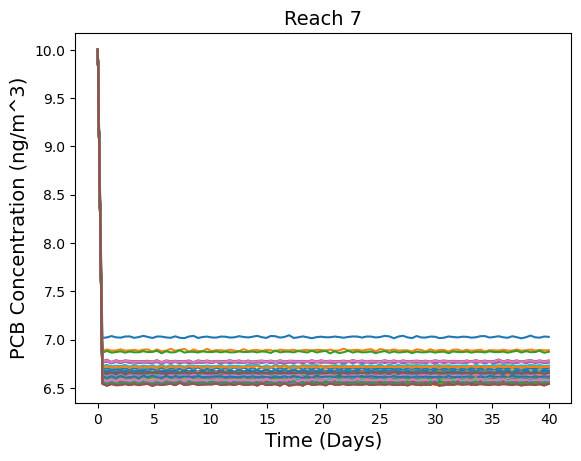

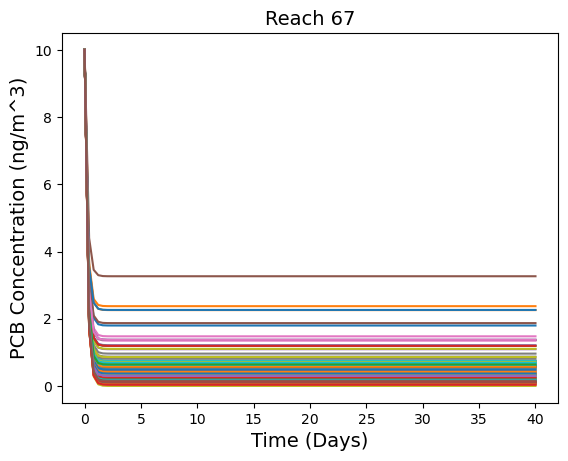

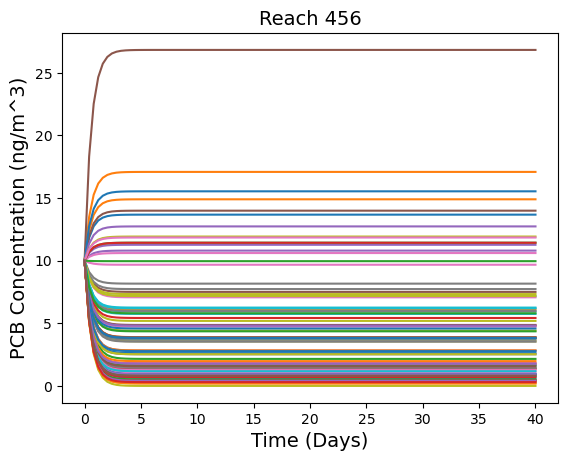

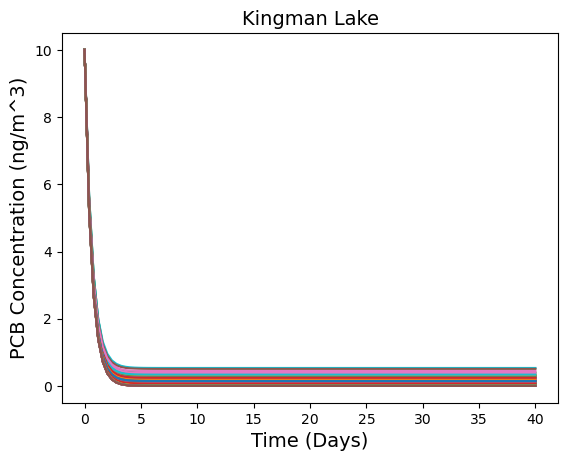

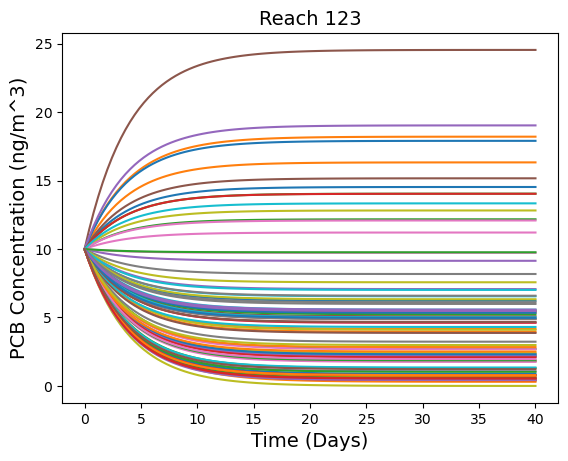

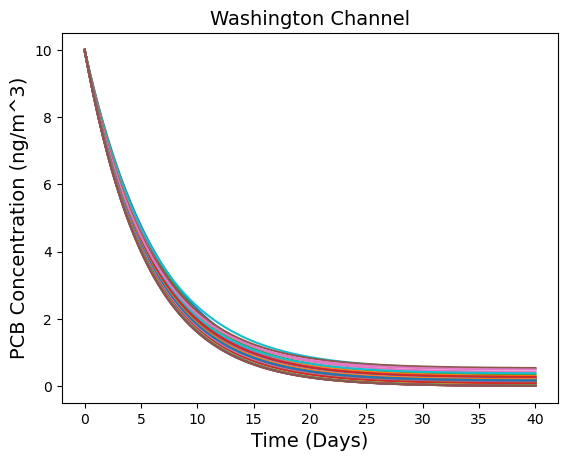

In [3]:
# Step 7 - collect results and plot
# Each graph is a separate file (instead of 1 file with 6 graphs on it) to make it easier to put graphs
# onto PowerPoint presentation

fig7, ax7 = plt.subplots()
for i in range(0, len(CongenerParameters['PCB congener'])):
    ax7.plot(ts_fp, R7_conc[i])
ax7.set_title('Reach 7', fontsize = 14)
ax7.set_xlabel('Time (Days)', fontsize = 14)
ax7.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
fig7.savefig('Reach 7 Graph.png')

fig67, ax67 = plt.subplots()
for i in range(0, len(CongenerParameters['PCB congener'])):
    ax67.plot(ts_fp, R67_conc[i])
ax67.set_title('Reach 67', fontsize = 14)
ax67.set_xlabel('Time (Days)', fontsize = 14)
ax67.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
fig67.savefig('Reach 67 Graph.png')

fig456, ax456 = plt.subplots()
for i in range(0, len(CongenerParameters['PCB congener'])):
    ax456.plot(ts_fp, R456_conc[i])
ax456.set_title('Reach 456', fontsize = 14)
ax456.set_xlabel('Time (Days)', fontsize = 14)
ax456.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
fig456.savefig('Reach 456 Graph.png')

figKL, axKL = plt.subplots()
for i in range(0, len(CongenerParameters['PCB congener'])):
    axKL.plot(ts_fp, KL_conc[i])
axKL.set_title('Kingman Lake', fontsize = 14)
axKL.set_xlabel('Time (Days)', fontsize = 14)
axKL.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
figKL.savefig('Kingman Lake Graph.png')

fig123, ax123 = plt.subplots()
for i in range(0, len(CongenerParameters['PCB congener'])):
    ax123.plot(ts_fp, R123_conc[i])
ax123.set_title('Reach 123', fontsize = 14)
ax123.set_xlabel('Time (Days)', fontsize = 14)
ax123.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
fig123.savefig('Reach 123 Graph.png')

figWC, axWC = plt.subplots()
for i in range(0, len(CongenerParameters['PCB congener'])):
    axWC.plot(ts_fp, WC_conc[i])
axWC.set_title('Washington Channel', fontsize = 14)
axWC.set_xlabel('Time (Days)', fontsize = 14)
axWC.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
figWC.savefig('Washington Channel Graph.png')

This code block demonstrates other ways this model can be used, such as in determining the concentration of an individual congener or in determining the total PCB load in the river stretch, which is of interest for regulation and protecting human and ecological health.

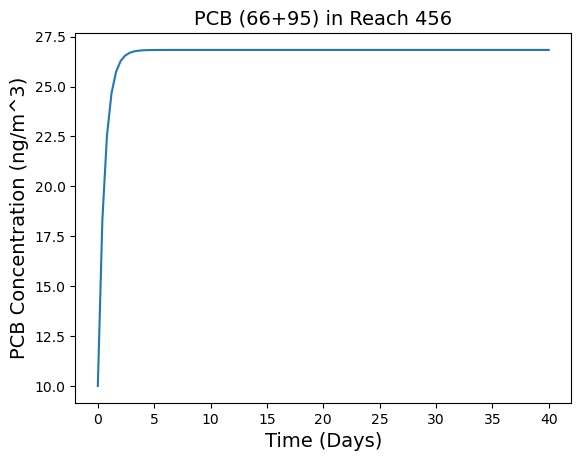

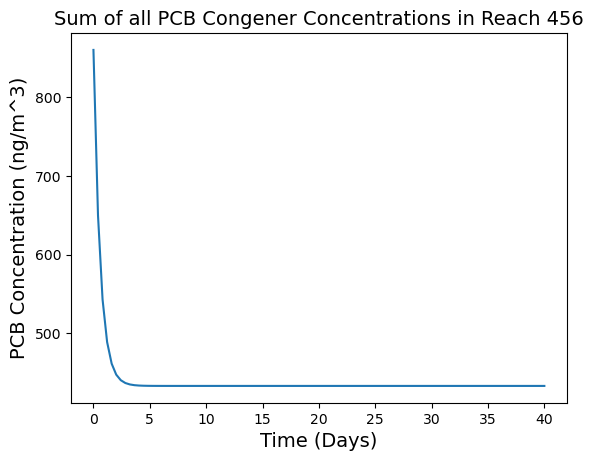

In [4]:
# These are 2 additional graphs generated to further demonstrate the utility of our model

figPCB35_R456, axPCB35_R456 = plt.subplots()
axPCB35_R456.plot(ts_fp, R456_conc[35])
axPCB35_R456.set_title('PCB (66+95) in Reach 456', fontsize = 14)
axPCB35_R456.set_xlabel('Time (Days)', fontsize = 14)
axPCB35_R456.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
figPCB35_R456.savefig('PCB (66+95) in Reach 456 Graph.png')

figPCBSum_R456, axPCBSum_R456 = plt.subplots()
axPCBSum_R456.plot(ts_fp, sum(R456_conc))
axPCBSum_R456.set_title('Sum of all PCB Congener Concentrations in Reach 456', fontsize = 14)
axPCBSum_R456.set_xlabel('Time (Days)', fontsize = 14)
axPCBSum_R456.set_ylabel('PCB Concentration (ng/m^3)', fontsize = 14)
figPCBSum_R456.savefig('Sum of all PCB Congener Concentrations in Reach 456.png')

The following code blocks are for modeling a hypothetical biosensor to test the response achieved when the biosensor detects a PCB in the water column. This code will be used to validate the idea that biosensors are a viable technology to detect PCBs in the water column and measure their concentrations, therefore speeding up the process of sampling for PCBs in environmental matrices.

**Cell below is for pulling in data files and making list and dataframes for further manipulation.**

In [5]:
# imports excel file with relevant enzymatic constants
Enzymes = pd.read_csv('PCB enzyme kinetics constants2.csv')
Enzymes

# makes a dataframe to add relevant data/constants into
finaldata = pd.DataFrame(columns=['Enzyme','Km','Vmax','[PCB]','v_curve'])

# makes a list of enzyme code, Km and Vmax values from the enzyme list
enzdata = np.array([Enzymes['Enzyme code'],Enzymes['Vmax(umol*min-1*mg-1)'], Enzymes['Km (uM)']]).T

# makes a list of Km values from the enzyme list
enz_list = enzdata[:, 0]

# makes a list of Km values from the enzyme list
km_list = enzdata[:, 2]

# makes a list of Vmax values from the enzyme list
vmax_list = enzdata[:, 1]  # umol * min-1 * mg-1

# PCB concentrations get inserted here (micromolar concentrations)
s_array = np.arange(0,0.001,0.00001)

In [6]:
# pulls enzymatic constants into dataframe
finaldata.loc[:,'Enzyme']=enz_list
finaldata.loc[:,'Vmax']=vmax_list
finaldata.loc[:,'Km']=km_list

# processes PCB values into a list of lists for further calculations
s_list = []
s_data = []
for item in s_array:
    s_list.append(item)

for i in vmax_list:
        s_data.append(s_list)

# test to ensure the PCB values look correct and you are getting a list of lists
#print(s_data)

# test to make sure list is the correct length, should be equal to number of rows in dataframe
print(len(s_data))

# test to make sure data is of the correct type, should all be type=object
finaldata["Vmax"] = finaldata["Vmax"].astype(object)
finaldata
result = finaldata.dtypes
print("Output:")
print(result)

38
Output:
Enzyme     object
Km         object
Vmax       object
[PCB]      object
v_curve    object
dtype: object


In [7]:
# test to make sure enzyme constants are loaded into dataframe correctly and to check number of rows 
# for tests in next cell
print(len(finaldata['Vmax']))
print(len(finaldata['Km']))
finaldata

38
38


,Enzyme,Km,Vmax,[PCB],v_curve
0,Q8GJ27 (PCE),20.0,15.0,NaN,NaN
1,Q8GJ27 (TCE),24.0,20.28,NaN,NaN
2,Q69GM4 (VC),13.0,1.006,NaN,NaN
3,"Q69GM4 (1,1-DCE)",45.0,0.3,NaN,NaN
4,Q8RQC9 (3-C-4-HBA),12.4,14.8,NaN,NaN
5,"Q8RQC9 (3,5-DC-4-HBA)",12.3,37.9,NaN,NaN
6,Q8RQC9 (3-c-4-HPA),310.0,5.5,NaN,NaN
7,"Q8RQC9 (2,3-DCPh)",334.0,10.2,NaN,NaN
8,"Q8RQC9 (2,4,6-DCPh)",160.0,12.6,NaN,NaN
9,Q8RQC9 (PentaCPh),390.0,1.94,NaN,NaN


In [8]:
# test to ensure the calculations are proceeding correctly
# change the numbers '15' and '20' to match enzyme constants in first row of dataframe
# When you produce all the enzymatic data later this list should match the first list printed

test=[]

for s in s_array:
    sss=((15 * s) / (20 + s))
    test.append(sss)

print(test)

[0.0, 7.499996250001876e-06, 1.4999985000015002e-05, 2.249996625005063e-05, 2.9999940000120004e-05, 3.749990625023437e-05, 4.4999865000405e-05, 5.2499816250643126e-05, 5.999976000096e-05, 6.749969625136688e-05, 7.499962500187499e-05, 8.249954625249561e-05, 8.999946000324e-05, 9.749936625411937e-05, 0.00010499926500514499, 0.00011249915625632809, 0.00011999904000767995, 0.0001274989162592118, 0.00013499878501093492, 0.00014249864626286052, 0.00014999850001499985, 0.0001574983462673642, 0.00016499818501996478, 0.00017249801627281286, 0.0001799978400259197, 0.0001874976562792965, 0.00019499746503295458, 0.00020249726628690512, 0.00020999706004115945, 0.0002174968462957287, 0.00022499662505062428, 0.00023249639630585725, 0.00023999616006143906, 0.0002474959163173808, 0.00025499566507369376, 0.00026249540633038927, 0.00026999514008747843, 0.0002774948663449727, 0.0002849945851028831, 0.000292494296361221, 0.00029999400011999764, 0.0003074936963792243, 0.0003149933851389121, 0.00032249306639

**This cell returns the predicted biosensor responses using the constants supplied in the dataframe**

In [9]:
v_data=[]
v=[]

# This code returns the predicted biosensor responses using the constants supplied in the dataframe
for index, row in finaldata.iterrows():
    #print(row['Enzyme'], row['Km'], row['Vmax'])
    s=1
    v = []
    for s in s_list:
        velocity=((row['Vmax'] * s) / (row['Km'] + s))
        v.append(velocity)
    v_data.append(v)

#print(v_data)

# Outputs are stored back into the main dataframe
finaldata['[PCB]'] = pd.Series(s_data)
finaldata['v_curve'] = pd.Series(v_data)

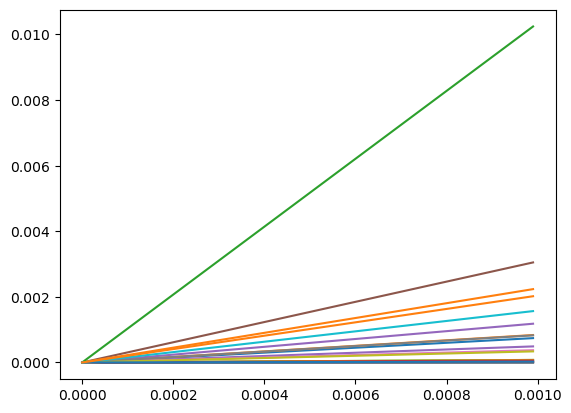

In [10]:
#to compare plotly to matplotlib
for i, row in finaldata.iterrows():
    plt.plot(row['[PCB]'], row['v_curve'])

**Cell bellow handles all the plotly code to generate an interactive plot.
This allows you to pick out specific enzymes from a large list more easily.**

In [11]:
fig = go.Figure()

for i,row in finaldata.iterrows():
    fig.add_trace(go.Scatter(x=row['[PCB]'], y=row['v_curve'],
                         mode='lines',
                         name=row['Enzyme'],
                         connectgaps=True,
                            ))


fig.update_layout(
    title="Predicted Biosensor Response",
    yaxis_title="Predicted Sensor Response (RFU)",
    xaxis_title="PCB Concentration (uM)",
    font=dict(
        family="arial",
        size=20,
        color = '#000000',
    ))

fig
fig.write_html('XXXX.html', auto_open=True)

PCB list (recognized by enzyme)

149
153
105
130
187
185
172
170
198
203
132
95
91
174
9
52
47
183
85
118
66
26
25
29